In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [3]:
import re
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df_x = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 0, usecols = [1,2,3,4,5,6])
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
print(len(df_x))
df_x.head()

24


,Buffer_Type,pH,Sugar_Salt,Additive,Additive_Conc_mM_,PS20_Conc_
0,Ace,4.5,4% Sorbitol,Arginine,40,0.02
1,Ace,4.5,4% Sorbitol,Glycine,40,0.02
2,Ace,5.0,4% Sorbitol,Arginine,40,0.02
3,Ace,5.0,4% Sorbitol,Glycine,40,0.02
4,Ace,5.0,0.1M NaCl,Glycine,40,0.02


In [24]:

df_y_1 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [1,4,7],skiprows = lambda x: x in [1])
df_y_1.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_y_1.columns]
print(len(df_y_1))
print(df_y_1.head())

df_y_2 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [2,5,8],skiprows = lambda x: x in [1])
df_y_2.columns = df_y_1.columns
print(len(df_y_2))
print(df_y_2.head())

df_y_3 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [3,6,9],skiprows = lambda x: x in [1])
df_y_3.columns = df_y_1.columns
print(len(df_y_3))
print(df_y_3.head())



24
   _Dimer_HMW_  _Monomer  _LMW
0          2.4      95.1   2.5
1          0.8      97.3   2.0
2          3.2      94.3   2.6
3          1.4      96.7   1.9
4          4.2      93.3   2.5
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.6      96.2   2.2
1          1.1      96.6   2.2
2          2.0      95.6   2.4
3          1.4      96.4   2.3
4          2.3      95.2   2.4
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.8      93.8   4.4
1          0.7      95.1   4.2
2          2.7      93.4   3.9
3          1.3      95.0   3.6
4          3.4      92.7   4.0


In [25]:
total_df_y_long = pd.concat((df_y_1,df_y_2,df_y_3),axis = 0)

In [27]:
cols_feature01 = list(df_x.columns)
cols_target = list(df_y_1.columns)[0:2]
#cols_target = ['UP_SEC_HMW','UP_SEC_LMW']
cols_cate = ['Buffer_Type',
 'Sugar_Salt',
 'Additive']

In [28]:
df_y_1.columns = [c+'_1' for c in df_y_1.columns]
df_y_2.columns = [c+'_2' for c in df_y_2.columns]
df_y_3.columns = [c+'_3' for c in df_y_3.columns]


In [29]:
total_df = pd.concat((df_x,df_y_1,df_y_2,df_y_3),axis = 1)

#convert Buffer column to labels
for x_name in cols_cate:
    labels, categories = factorize(total_df[x_name])
    total_df[x_name+"_label"] = labels

In [30]:
#onehot encoding
total_df = pd.get_dummies(total_df, columns = cols_cate)
#print(total_df.head())
total_df.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in total_df.columns]

#convert boolean True False to 0 1
bool_cols = total_df.select_dtypes(include='bool').columns
total_df[bool_cols] = total_df[bool_cols].astype(int)
print(total_df.head())



    pH  Additive_Conc_mM_  PS20_Conc_  _Dimer_HMW_1  _Monomer_1  _LMW_1  \
0  4.5                 40        0.02           2.4        95.1     2.5   
1  4.5                 40        0.02           0.8        97.3     2.0   
2  5.0                 40        0.02           3.2        94.3     2.6   
3  5.0                 40        0.02           1.4        96.7     1.9   
4  5.0                 40        0.02           4.2        93.3     2.5   

   _Dimer_HMW_2  _Monomer_2  _LMW_2  _Dimer_HMW_3  ...  Sugar_Salt_label  \
0           1.6        96.2     2.2           1.8  ...                 0   
1           1.1        96.6     2.2           0.7  ...                 0   
2           2.0        95.6     2.4           2.7  ...                 0   
3           1.4        96.4     2.3           1.3  ...                 0   
4           2.3        95.2     2.4           3.4  ...                 1   

   Additive_label  Buffer_Type_Ace  Buffer_Type_Cit  Buffer_Type_His  \
0               0   

In [31]:
ls_model = ['simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


model_option = 'simpleGP'
x_scale_option = 'x-minmax'
y_scale_option = 'y-minmax'
cate_transform_option = 'ohe'
remove_pred_outlier_option= 0



model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option
remove_pred_outlier_label = 'remove_pred_outlier_'+str(remove_pred_outlier_option)

folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_transform_label,
                        remove_pred_outlier_label])

figPath = 'output-harpoon/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

In [32]:
if cate_transform_option == 'label':
    cols_feature_new = ['pH', 'Additive_Conc_mM_', 'PS20_Conc_'] + ['Buffer_Type_label', 'Sugar_Salt_label',
       'Additive_label']
else:
    cols_feature_new = ['pH', 'Additive_Conc_mM_', 'PS20_Conc_'] + list(bool_cols)

cols_target_new = ['_Dimer_HMW_1', '_Monomer_1',
       '_Dimer_HMW_2', '_Monomer_2', 
       '_Dimer_HMW_3','_Monomer_3']

In [33]:
##Split the data into training and testing sets
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(total_df[cols_feature_new], total_df[cols_target_new], test_size=0.2, random_state=0)

array([[<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'Additive_Conc_mM_'}>,
        <Axes: title={'center': 'PS20_Conc_'}>],
       [<Axes: title={'center': 'Buffer_Type_Ace'}>,
        <Axes: title={'center': 'Buffer_Type_Cit'}>,
        <Axes: title={'center': 'Buffer_Type_His'}>],
       [<Axes: title={'center': 'Buffer_Type_Phos'}>,
        <Axes: title={'center': 'Sugar_Salt_0_1M_NaCl'}>,
        <Axes: title={'center': 'Sugar_Salt_4_Sorbitol'}>],
       [<Axes: title={'center': 'Additive_Arginine'}>,
        <Axes: title={'center': 'Additive_Glycine'}>, <Axes: >]],
      dtype=object)

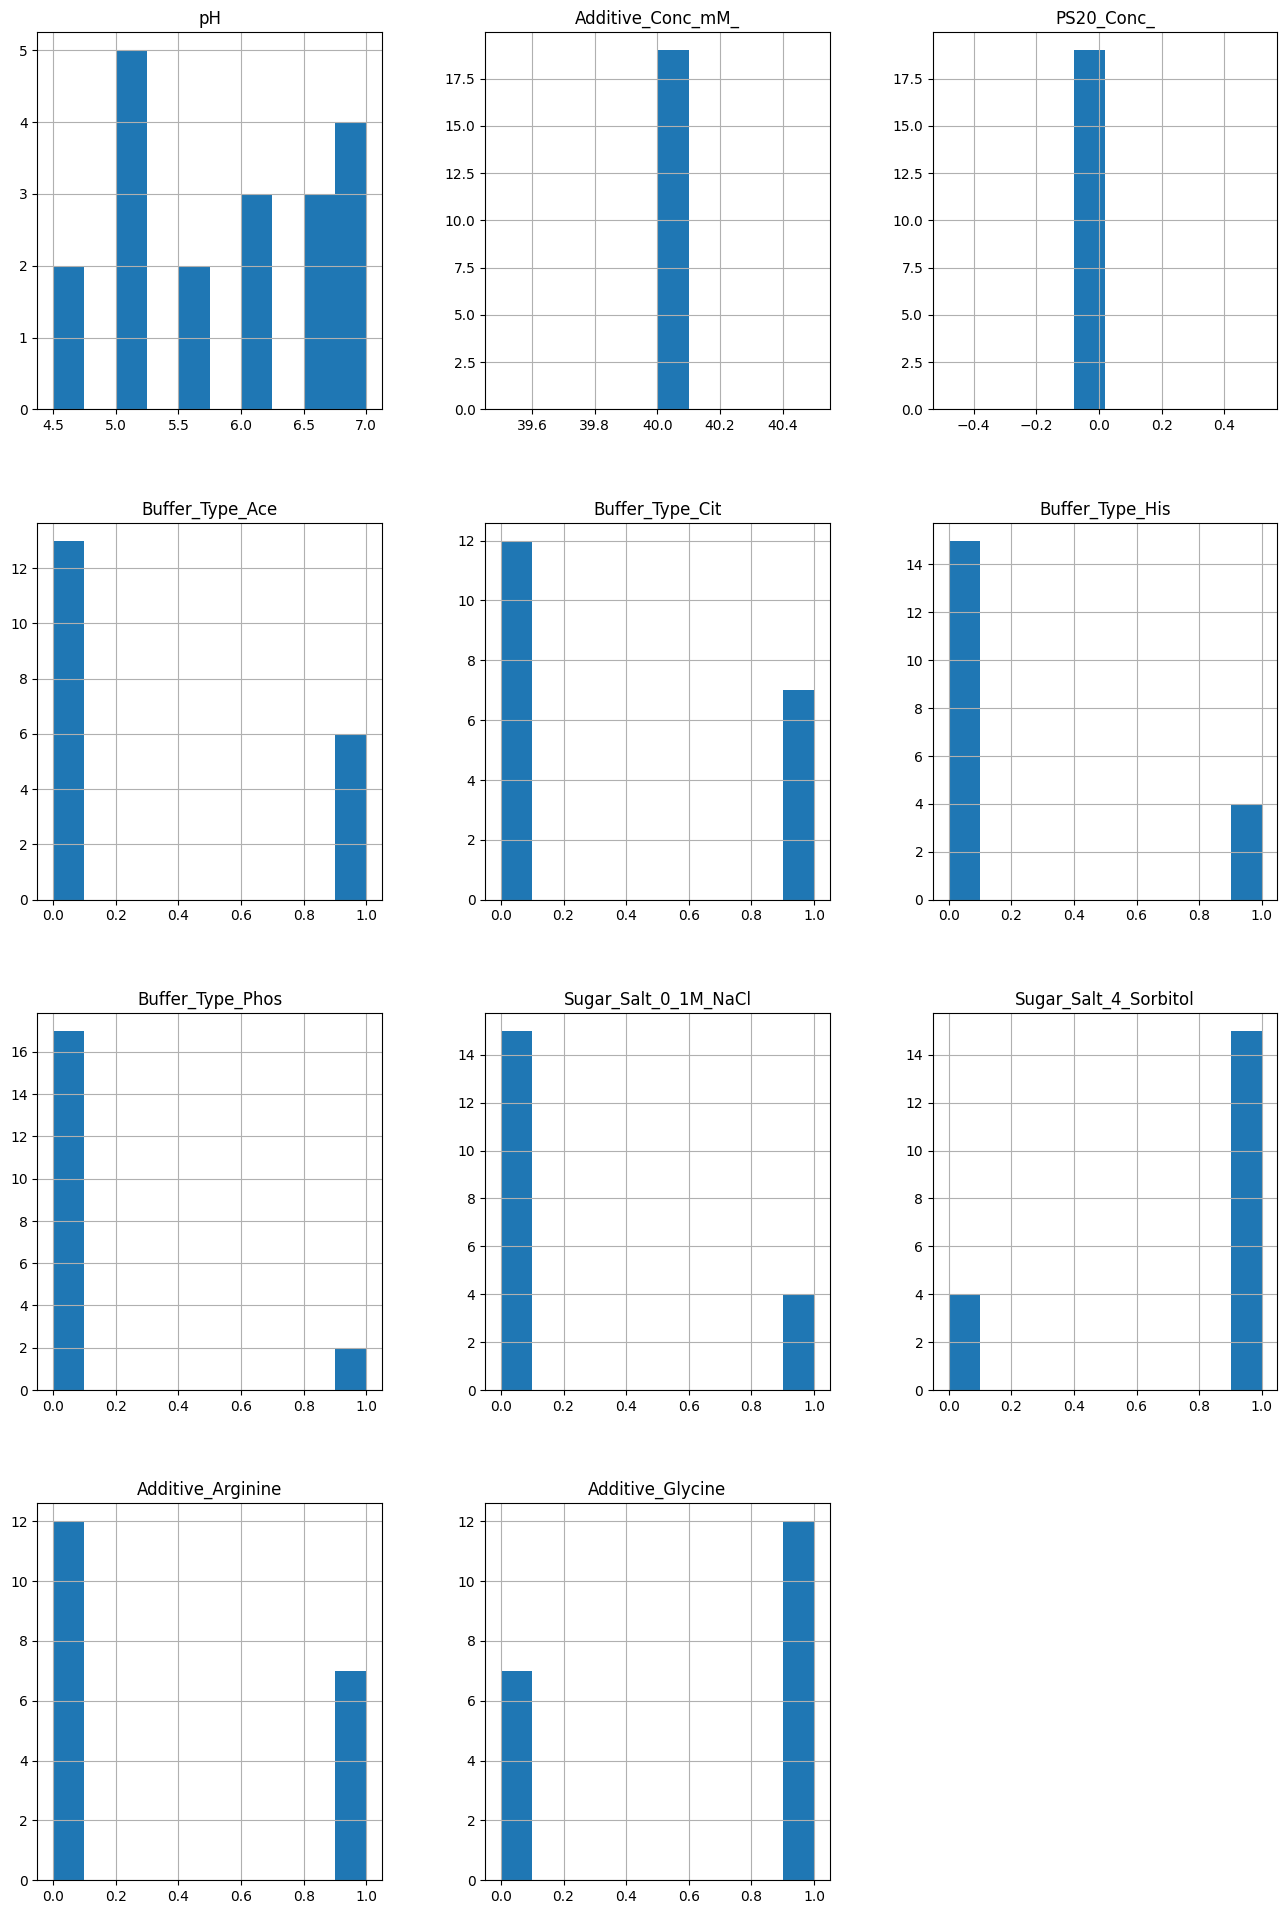

In [15]:
df_X_train.hist(figsize = (16,24))

In [34]:
# scale features
x_mm_scaler = MinMaxScaler()

scaled_X_train=x_mm_scaler.fit_transform(df_X_train) 
scaled_X_test=x_mm_scaler.transform(df_X_test)

"""
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    scaled_y_test = df_y_test.to_numpy()
"""

"\nif y_scale_label == 'y-robust':\n    y_scaler = RobustScaler()\n    scaled_y_train = y_scaler.fit_transform(df_y_train)\n    scaled_y_test= y_scaler.transform(df_y_test)\nelif y_scale_label == 'y-stand':\n    y_scaler = StandardScaler()\n    scaled_y_train = y_scaler.fit_transform(df_y_train)\n    scaled_y_test= y_scaler.transform(df_y_test)\nelif y_scale_label == 'y-minmax':\n    y_scaler = MinMaxScaler()\n    scaled_y_train = y_scaler.fit_transform(df_y_train)\n    scaled_y_test= y_scaler.transform(df_y_test)\nelse:\n    scaled_y_train = df_y_train.to_numpy()\n    scaled_y_test = df_y_test.to_numpy()\n"

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>]],
      dtype=object)

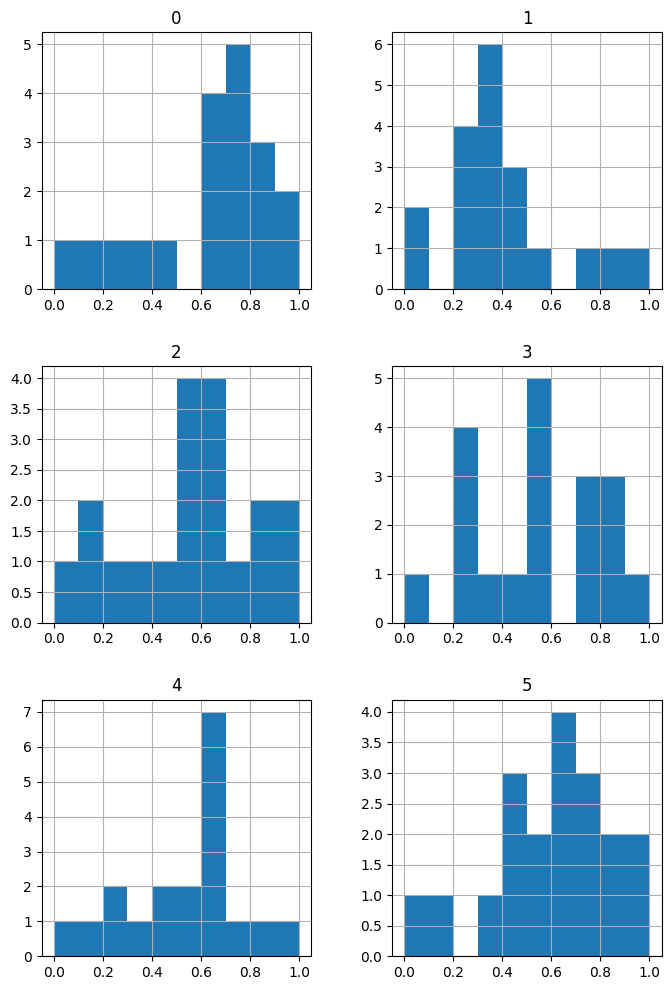

In [19]:
df_scaled_y_train = pd.DataFrame(scaled_y_train)
df_scaled_y_train.hist(figsize = (8,12))

array([[<Axes: title={'center': '_Dimer_HMW_1'}>,
        <Axes: title={'center': '_Monomer_1'}>],
       [<Axes: title={'center': '_Dimer_HMW_2'}>,
        <Axes: title={'center': '_Monomer_2'}>],
       [<Axes: title={'center': '_Dimer_HMW_3'}>,
        <Axes: title={'center': '_Monomer_3'}>]], dtype=object)

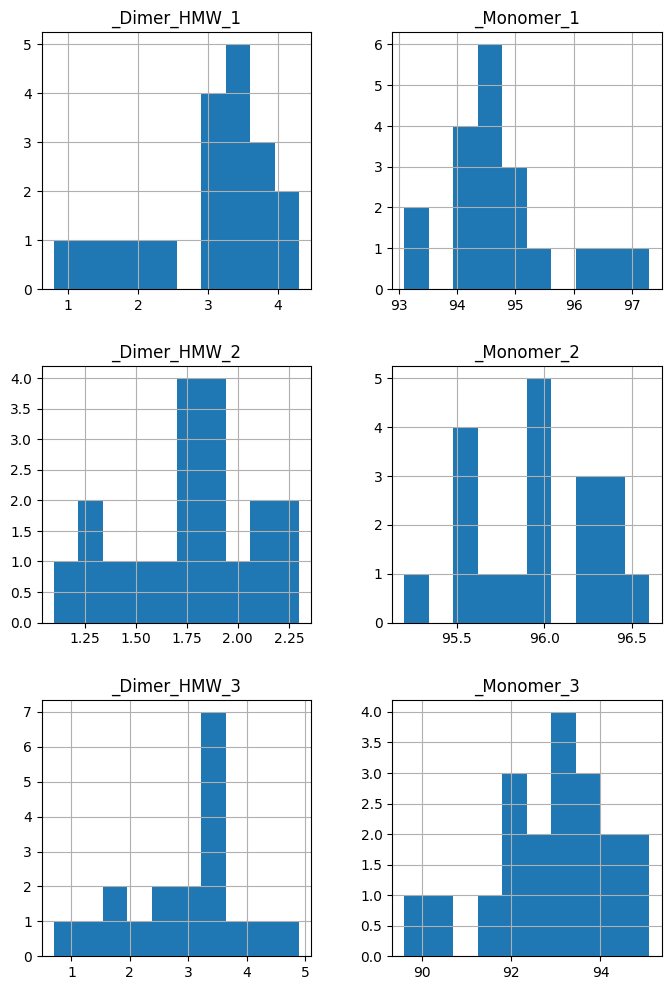

In [35]:
df_y_train.hist(figsize = (8,12))

In [37]:
y_train_all=df_y_train.values
    

In [41]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))

1.07**2 * RBF(length_scale=0.46)
1.06**2 * RBF(length_scale=0.466)
0.988**2 * RBF(length_scale=0.198)


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_59928/118798942.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_59928/118798942.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_59928/118798942.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black',markersize=10)
/v

1.02**2 * RBF(length_scale=0.227)
1.95**2 * RBF(length_scale=1.25)
1.08**2 * RBF(length_scale=0.343)


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_59928/118798942.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_59928/118798942.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_59928/118798942.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black',markersize=10)
/v

         _Dimer_HMW_1  _Monomer_1  _Dimer_HMW_2  _Monomer_2  _Dimer_HMW_3  \
MAE              0.37        0.69          0.12        0.17          0.31   
MAE2             0.38        0.70          0.04        0.05          0.34   
MSE              0.18        0.64          0.03        0.07          0.14   
RMSE             0.43        0.80          0.16        0.26          0.37   
MAPE             0.11        0.01          0.08        0.00          0.08   
MAXE             0.73        1.33          0.28        0.55          0.64   
EVS              0.80        0.46          0.71        0.64          0.64   
R2               0.71        0.28          0.71        0.48          0.63   
AVG_STD          0.55        0.62          0.27        0.31          0.59   
MIN_STD          0.22        0.25          0.24        0.25          0.05   
MAX_STD          0.96        1.08          0.32        0.38          1.31   

         _Monomer_3  
MAE            0.80  
MAE2           0.60  
MSE      

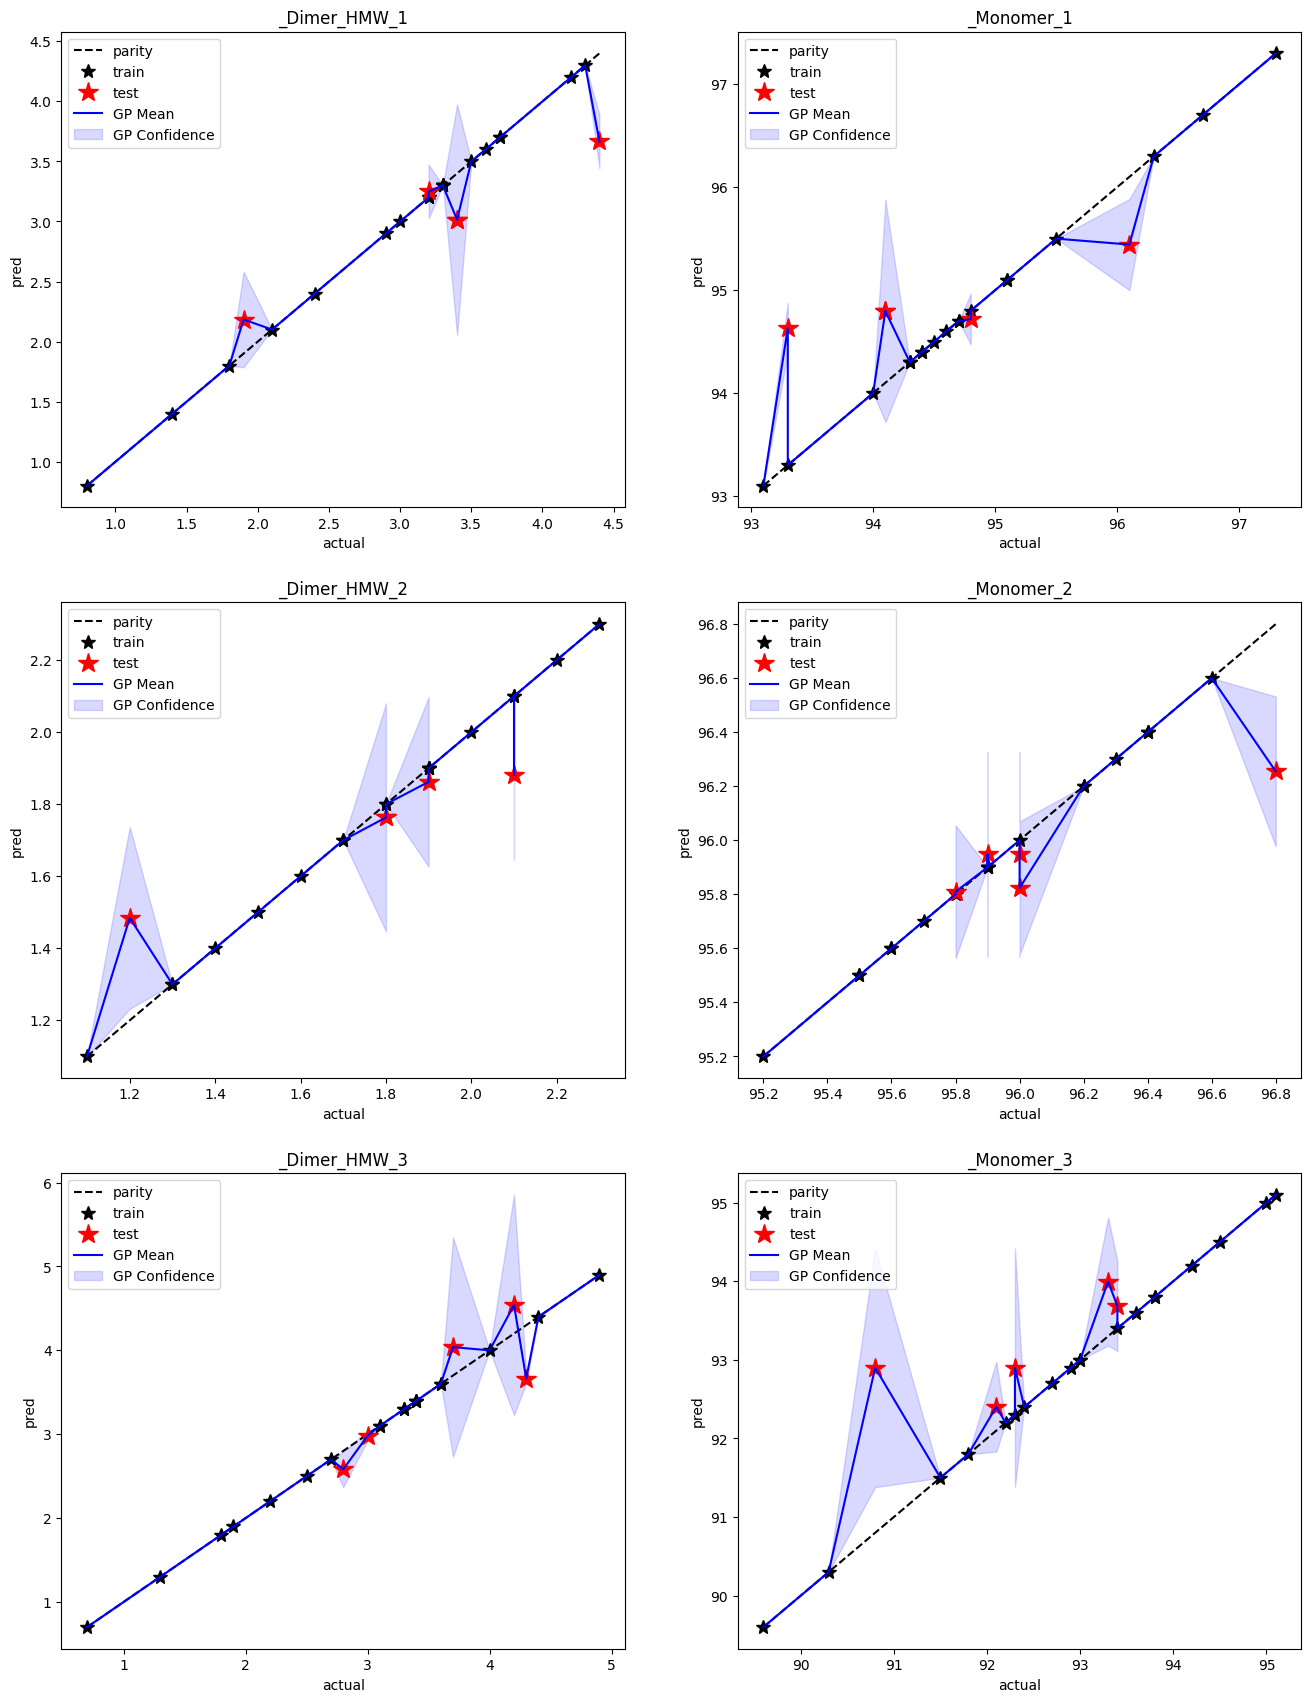

In [45]:
uncertainty_figure_option = 'shade' #shade or errorbar
is_set_axis_limit = False

plot_axis_lb = total_df_y_long[cols_target].min(axis = 0) - 0.4*total_df_y_long[cols_target].std(axis = 0)
plot_axis_ub = total_df_y_long[cols_target].max(axis = 0) + 0.4* total_df_y_long[cols_target].std(axis = 0)

num_outputs = len(cols_target)
num_tasks = 3

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    my_gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,normalize_y = True)
    
    y_train = y_train_all[:,a]
    my_gpr.fit(scaled_X_train,y_train)
    print(my_gpr.kernel_)
    mean_train_pred, std_train_pred = my_gpr.predict(scaled_X_train, return_std=True)
    mean_test_pred, std_test_pred = my_gpr.predict(scaled_X_test, return_std=True)
    y_true = df_y_test[tmp_col_y].values
    y_pred = mean_test_pred

    train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
    df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
    df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as black stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = "black")
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(std_test_pred),2)
    arr_test_metrics[9,a] = round(np.min(std_test_pred),2)
    arr_test_metrics[10,a] = round(np.max(std_test_pred),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
    arr_train_metrics[8,a] = round(np.mean(std_train_pred),2)
    arr_train_metrics[9,a] = round(np.min(std_train_pred),2)
    arr_train_metrics[10,a] = round(np.max(std_train_pred),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')